## TRABAJO FINAL MACHINE LEARNING
## John Steven Ceballos Agudelo


El problema de hoy consiste en realizar un modelo de predicción acerca de una transacción en un e-commerce es fraudulenta o no,
utilizando un dataset que contiene 19 variables (A a S) más una columna de
monto de la transacción, y la variable de respuesta denominada "fraude",
que indica si una transacción es fraudulenta (1) o no (0).

Para poder trabajar con nuestro dataset, importaremos las siguientes librerias:

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report


Leemos nuestro conjunto de datos proporcionados por el profesor y lo nombramos `data`

In [167]:
data = pd.read_csv("data.csv")

Veamos un poco de nuestro dataset...

In [168]:
data

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,Monto,Fraude
0,0,10,50257.0,0,0,0.000,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,7.25,37.51,1
1,0,10,29014.0,0,0,0.000,0.0,0,0,UY,...,0,1,1,0,3,0.00,0.00,11.66,8.18,1
2,0,7,92.0,0,1,0.000,0.0,0,1,UY,...,0,3,1,0,2,0.00,0.00,86.97,13.96,1
3,9,16,50269.0,0,0,0.000,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,2.51,93.67,1
4,0,8,8180.0,0,0,0.000,0.0,0,0,UY,...,0,1,1,0,1,0.00,0.00,25.96,135.40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16875,0,3,63302.0,0,1,0.500,0.0,0,0,BR,...,1,1,1,0,1,0.00,0.00,85.73,132.17,1
16876,0,12,825.0,0,0,0.000,0.0,0,0,BR,...,1,1,1,0,5,0.00,0.00,12.50,26.34,1
16877,1,3,81067.0,0,0,0.000,0.0,0,0,BR,...,0,1,1,0,1,0.00,0.00,24.16,195.63,1
16878,0,9,398372.0,0,0,0.000,0.0,0,0,BR,...,0,2,1,0,1,0.00,0.00,29.00,36.97,1


Vemos el tamaño de nuestras filas y columnas pertenecientes al dataset

In [169]:
print(data.shape)
print(data.columns)

(16880, 21)
Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'Monto', 'Fraude'],
      dtype='object')


Eliminamos espacios en blanco, cambiamos mayusculas por minusculas y reemplazamos espacios en blanco por guiones bajos para facilitar el trabajo de las features

In [170]:
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')

Revisemos cuantos valores nulos hay presentes en nuestro dataset

In [171]:
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_data[missing_data['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)

,Missing Values,Percentage
k,12864,76.208531
c,3197,18.939573


Como podemos observar la feature `k` y la feature `c` cuentan con valores nulos, en especial `k` por lo tanto esta feature no la incluiremos en el modelo,mas adelante trataremos la feature `c`

In [172]:
data.drop(['k'],axis=1,inplace=True)

Revisemos los valores unicos de nuestro dataset

In [173]:
data.nunique()

a           21
b           21
c         9782
d           31
e           23
f          153
g          106
h           14
i           17
j           19
l            8
m           11
n           10
o            4
p           14
q          605
r          109
s         6467
monto     9616
fraude       2
dtype: int64

Hay features como `c` , `s` , `monto` que tienen muchos valores unicos pero pueden ser importantes en el modelo por lo tanto los vamos a incluir

Usaremos `.info()` para ver la cantidad de valores nulos y el tipo de dato que es cada feature

In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       16880 non-null  int64  
 1   b       16880 non-null  int64  
 2   c       13683 non-null  float64
 3   d       16880 non-null  int64  
 4   e       16880 non-null  int64  
 5   f       16880 non-null  float64
 6   g       16880 non-null  float64
 7   h       16880 non-null  int64  
 8   i       16880 non-null  int64  
 9   j       16880 non-null  object 
 10  l       16880 non-null  int64  
 11  m       16880 non-null  int64  
 12  n       16880 non-null  int64  
 13  o       16880 non-null  int64  
 14  p       16880 non-null  int64  
 15  q       16880 non-null  object 
 16  r       16880 non-null  object 
 17  s       16880 non-null  float64
 18  monto   16880 non-null  object 
 19  fraude  16880 non-null  int64  
dtypes: float64(4), int64(12), object(4)
memory usage: 2.6+ MB


Como podemos observar estamos contando con 4 variables categoricas, lo cual esta mal ya que `new_q`, `new_r` , `new_monto` son numericas, la unica categoriaca es `j` que representa los prefijos de los paises.

El problema que esta sucediendo es que tras revisar el dataset encontre que hay valores separados por `,` por lo tanto las toma como tipo object.

Para solucionar esto usaremos la función de pandas `to_numeric` para convertir las cadenas de texto a numeros

In [175]:
data['q'] = pd.to_numeric(data['q'].str.replace(',', ''), errors='coerce')
data['r'] = pd.to_numeric(data['r'].str.replace(',', ''), errors='coerce')
data['monto'] = pd.to_numeric(data['monto'].str.replace(',', ''), errors='coerce')

Veamos un poco de cada feature y sus estadisticas

In [176]:
data.describe()

,a,b,c,d,e,f,g,h,i,l,m,n,o,p,q,r,s,monto,fraude
count,16880.000000,16880.000000,13683.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000
mean,0.309242,7.645379,39235.339984,0.198697,0.433709,0.015878,0.005200,0.050296,0.144076,0.432346,1.544135,1.091765,0.009419,1.630865,8.445394,1.994921,29.127720,161.837033,0.273164
std,1.094064,4.686494,91045.252879,2.042959,1.537297,0.098730,0.059419,0.531060,0.824761,0.663860,1.022385,0.408081,0.116606,1.088286,74.367729,38.222485,26.510548,275.499961,0.445597
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,0.050000,0.000000
25%,0.000000,4.000000,1172.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,9.560000,33.807500,0.000000
50%,0.000000,7.000000,6173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,20.640000,81.645000,0.000000
75%,0.000000,11.000000,26888.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000,39.212500,193.440000,1.000000
max,30.000000,20.000000,617324.000000,180.000000,45.000000,1.000000,1.000000,21.000000,24.000000,7.000000,13.000000,10.000000,3.000000,41.000000,2274.670000,2025.720000,99.970000,12538.440000,1.000000


* La columna `b` tiene un mínimo de -1, lo cual podría indicar un valor erróneo o un valor de entrada incorrecto, ya que la media y la mayoría de los valores parecen estar en un rango positivo.
* La columna `s` también muestra un valor mínimo de -1.



Contemos cuantos valores tienen -1

In [177]:
print("Valores de -1 en la columna 'b':", data['b'].value_counts().get(-1, 0))
print("Valores de -1 en la columna 's':", data['s'].value_counts().get(-1, 0))

Valores de -1 en la columna 'b': 125
Valores de -1 en la columna 's': 136


Observamos como pocos datos tienen valor `-1` por lo tanto los reemplazaremos por la mediana para asi evitarnos problemas con estas features

In [178]:
# Calcula la mediana de las columnas 'b' y 's' excluyendo los valores -1
median_b = data.loc[data['b'] != -1, 'b'].median()
median_s = data.loc[data['s'] != -1, 's'].median()

# Reemplaza los valores -1 con la mediana calculada
data['b'] = data['b'].replace(-1, median_b)
data['s'] = data['s'].replace(-1, median_s)

In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       16880 non-null  int64  
 1   b       16880 non-null  int64  
 2   c       13683 non-null  float64
 3   d       16880 non-null  int64  
 4   e       16880 non-null  int64  
 5   f       16880 non-null  float64
 6   g       16880 non-null  float64
 7   h       16880 non-null  int64  
 8   i       16880 non-null  int64  
 9   j       16880 non-null  object 
 10  l       16880 non-null  int64  
 11  m       16880 non-null  int64  
 12  n       16880 non-null  int64  
 13  o       16880 non-null  int64  
 14  p       16880 non-null  int64  
 15  q       16880 non-null  float64
 16  r       16880 non-null  float64
 17  s       16880 non-null  float64
 18  monto   16880 non-null  float64
 19  fraude  16880 non-null  int64  
dtypes: float64(7), int64(12), object(1)
memory usage: 2.6+ MB


Como podemos observar, la feature `c` cuenta con valores nulos por lo tanto para rellenarlos usramos el metodo de KNN el cual puede ser un poco costoso computacionalmente pero no es un gran poblema para este modelo ya que no son tantos datos.

Ademas anteriormente intente rellenarlos con otros parametros como la moda, mediana, etc... pero nos generaban una mayor varianza

In [180]:
imputer = KNNImputer(n_neighbors=5)
data[['c']] = imputer.fit_transform(data[['c']])
print(data['c'].isnull().sum())

0


Revisemos como se da la distribucion de las features...

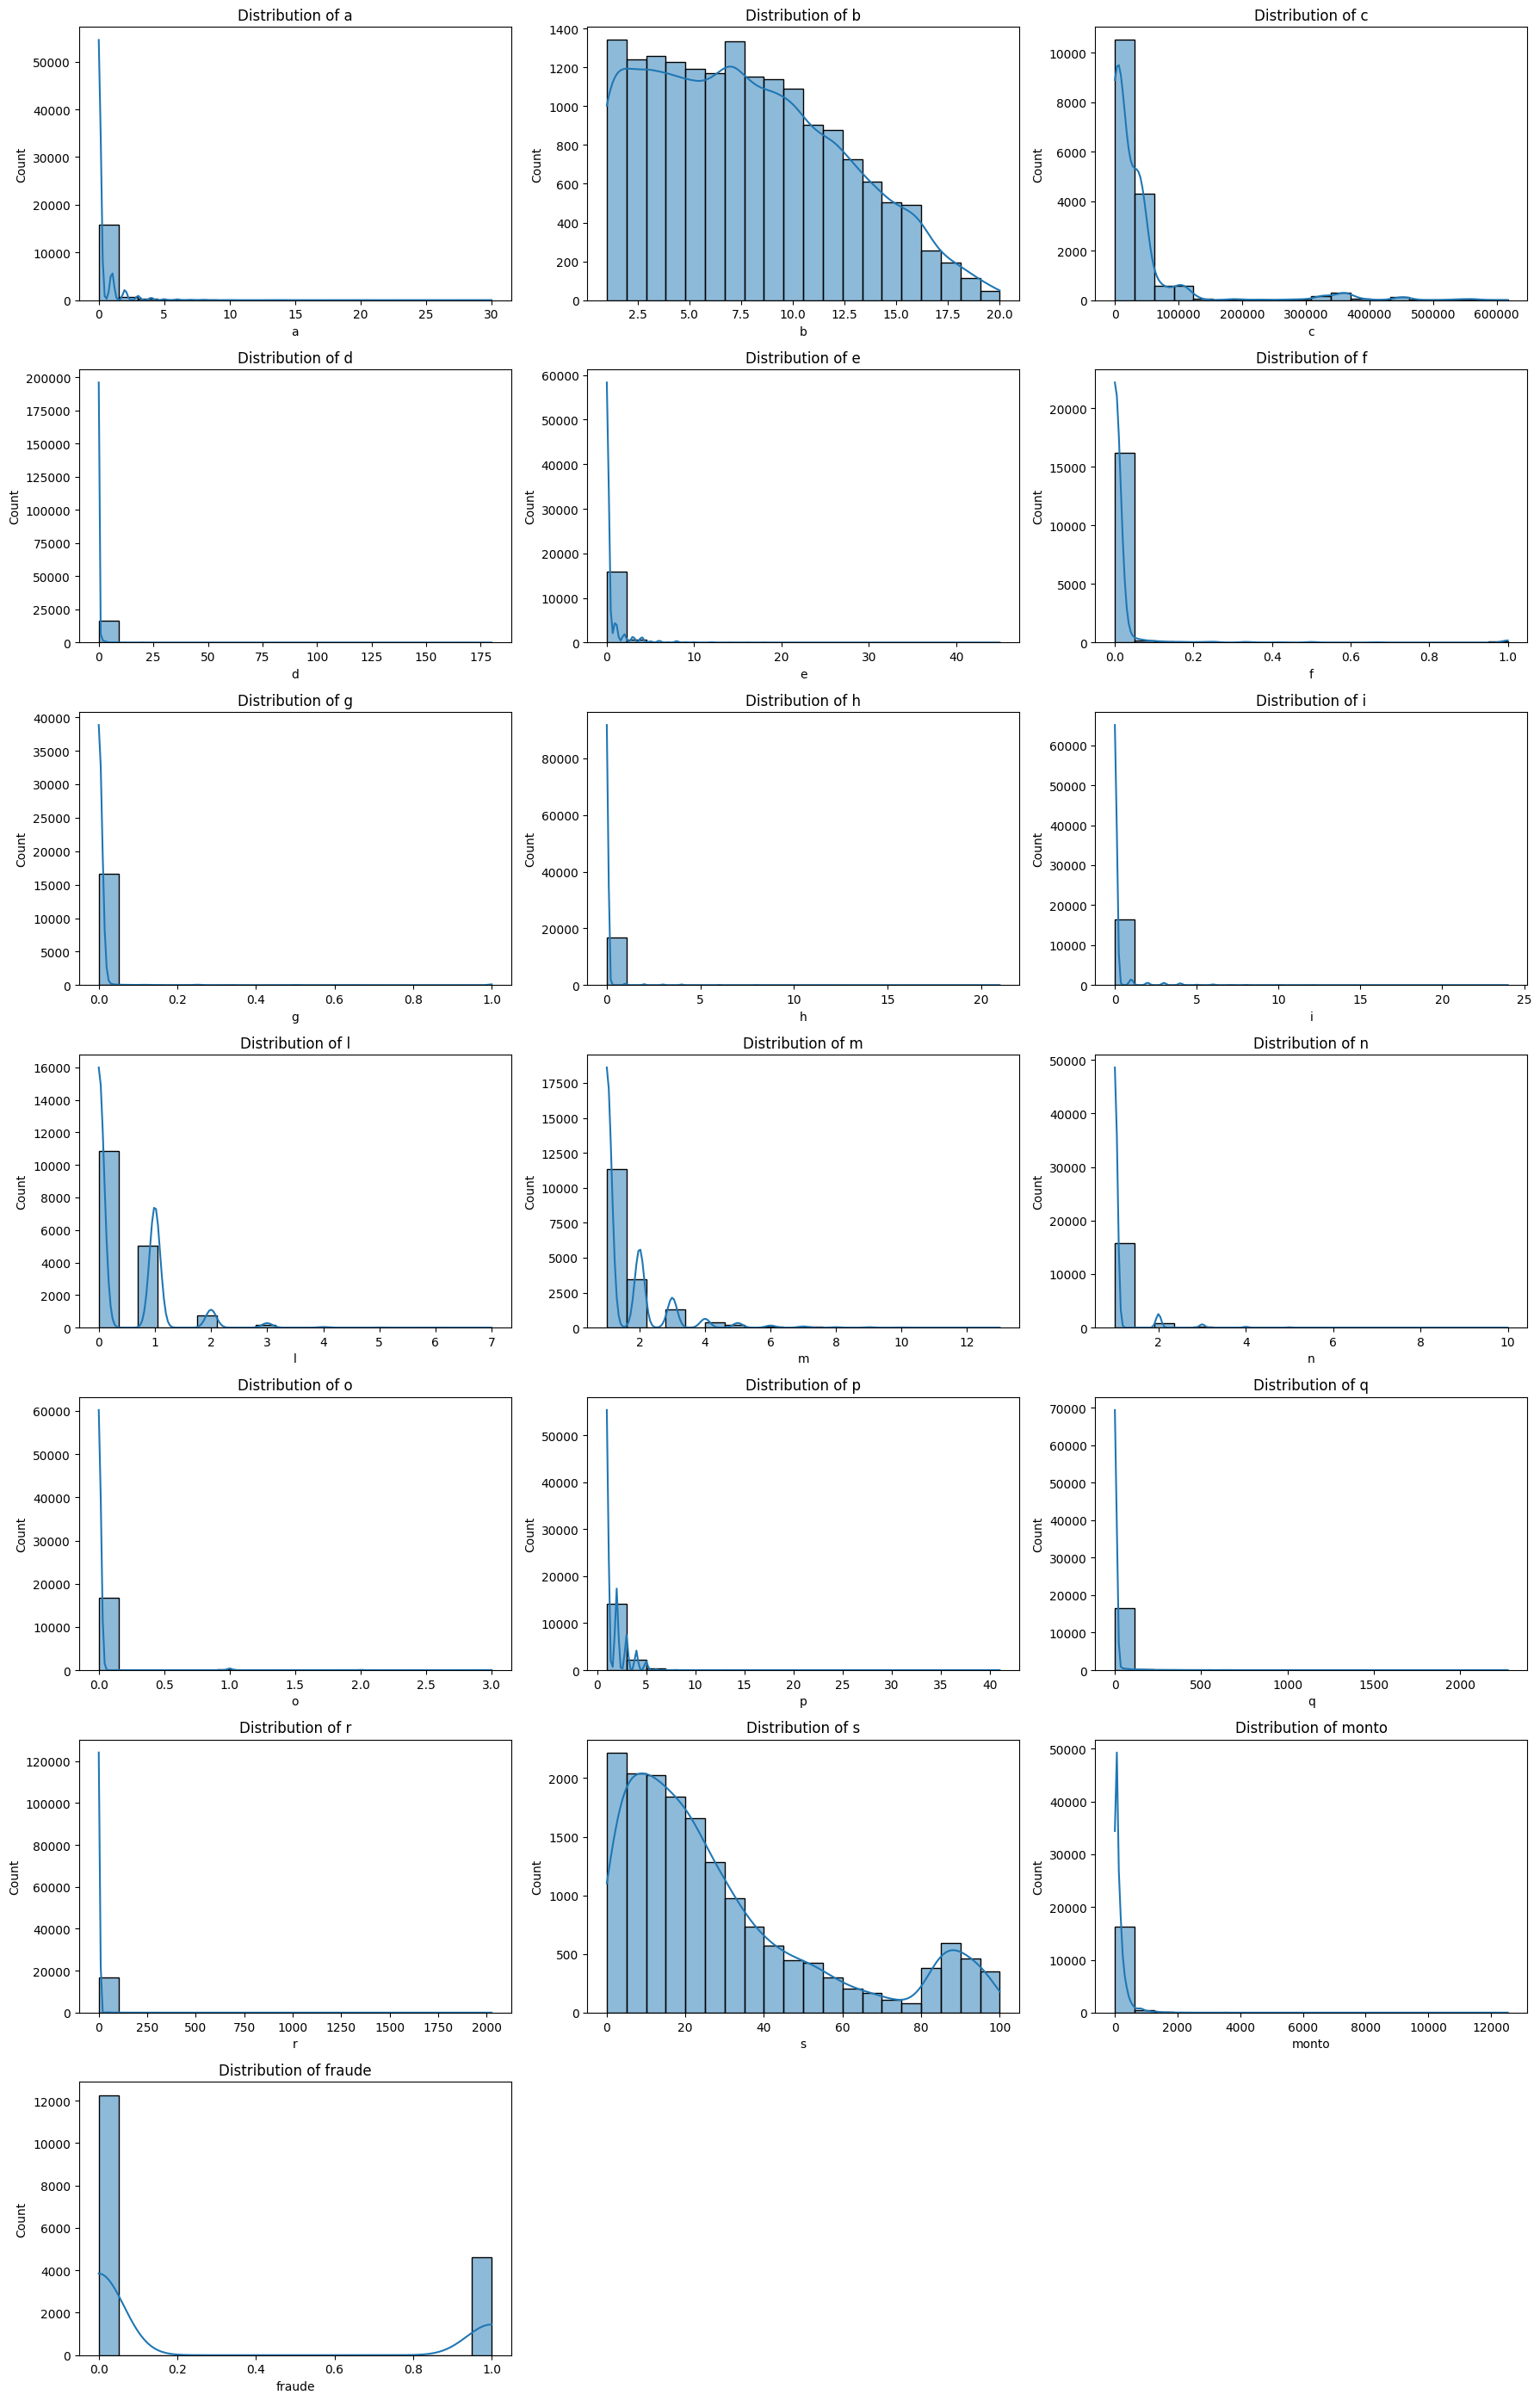

In [181]:
num_cols = 3
num_columns = data.select_dtypes(include=['float64', 'int64']).columns
num_rows = (len(num_columns) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4))
axes = axes.flatten()
for i, column in enumerate(num_columns):
    sns.histplot(data[column], kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

De las graficas podemos concluir lo siguiente:

* Distribución Sesgada: La mayoría de las variables ( `a, c, d, e, f, g, h, i, l, m, n, o, p, fraude, q, r, monto`) presentan una fuerte acumulación de valores en la parte baja del rango, indicando una distribución sesgada. Esto podría requerir transformaciones para normalizar los datos y mejorar la precisión del modelo.

* Distribución Más Uniforme: Variables como `b` y `s` tienen distribuciones más esparcidas.

Tambien realizemos diagramas de cajas y bigotes para detectar posibles outliers

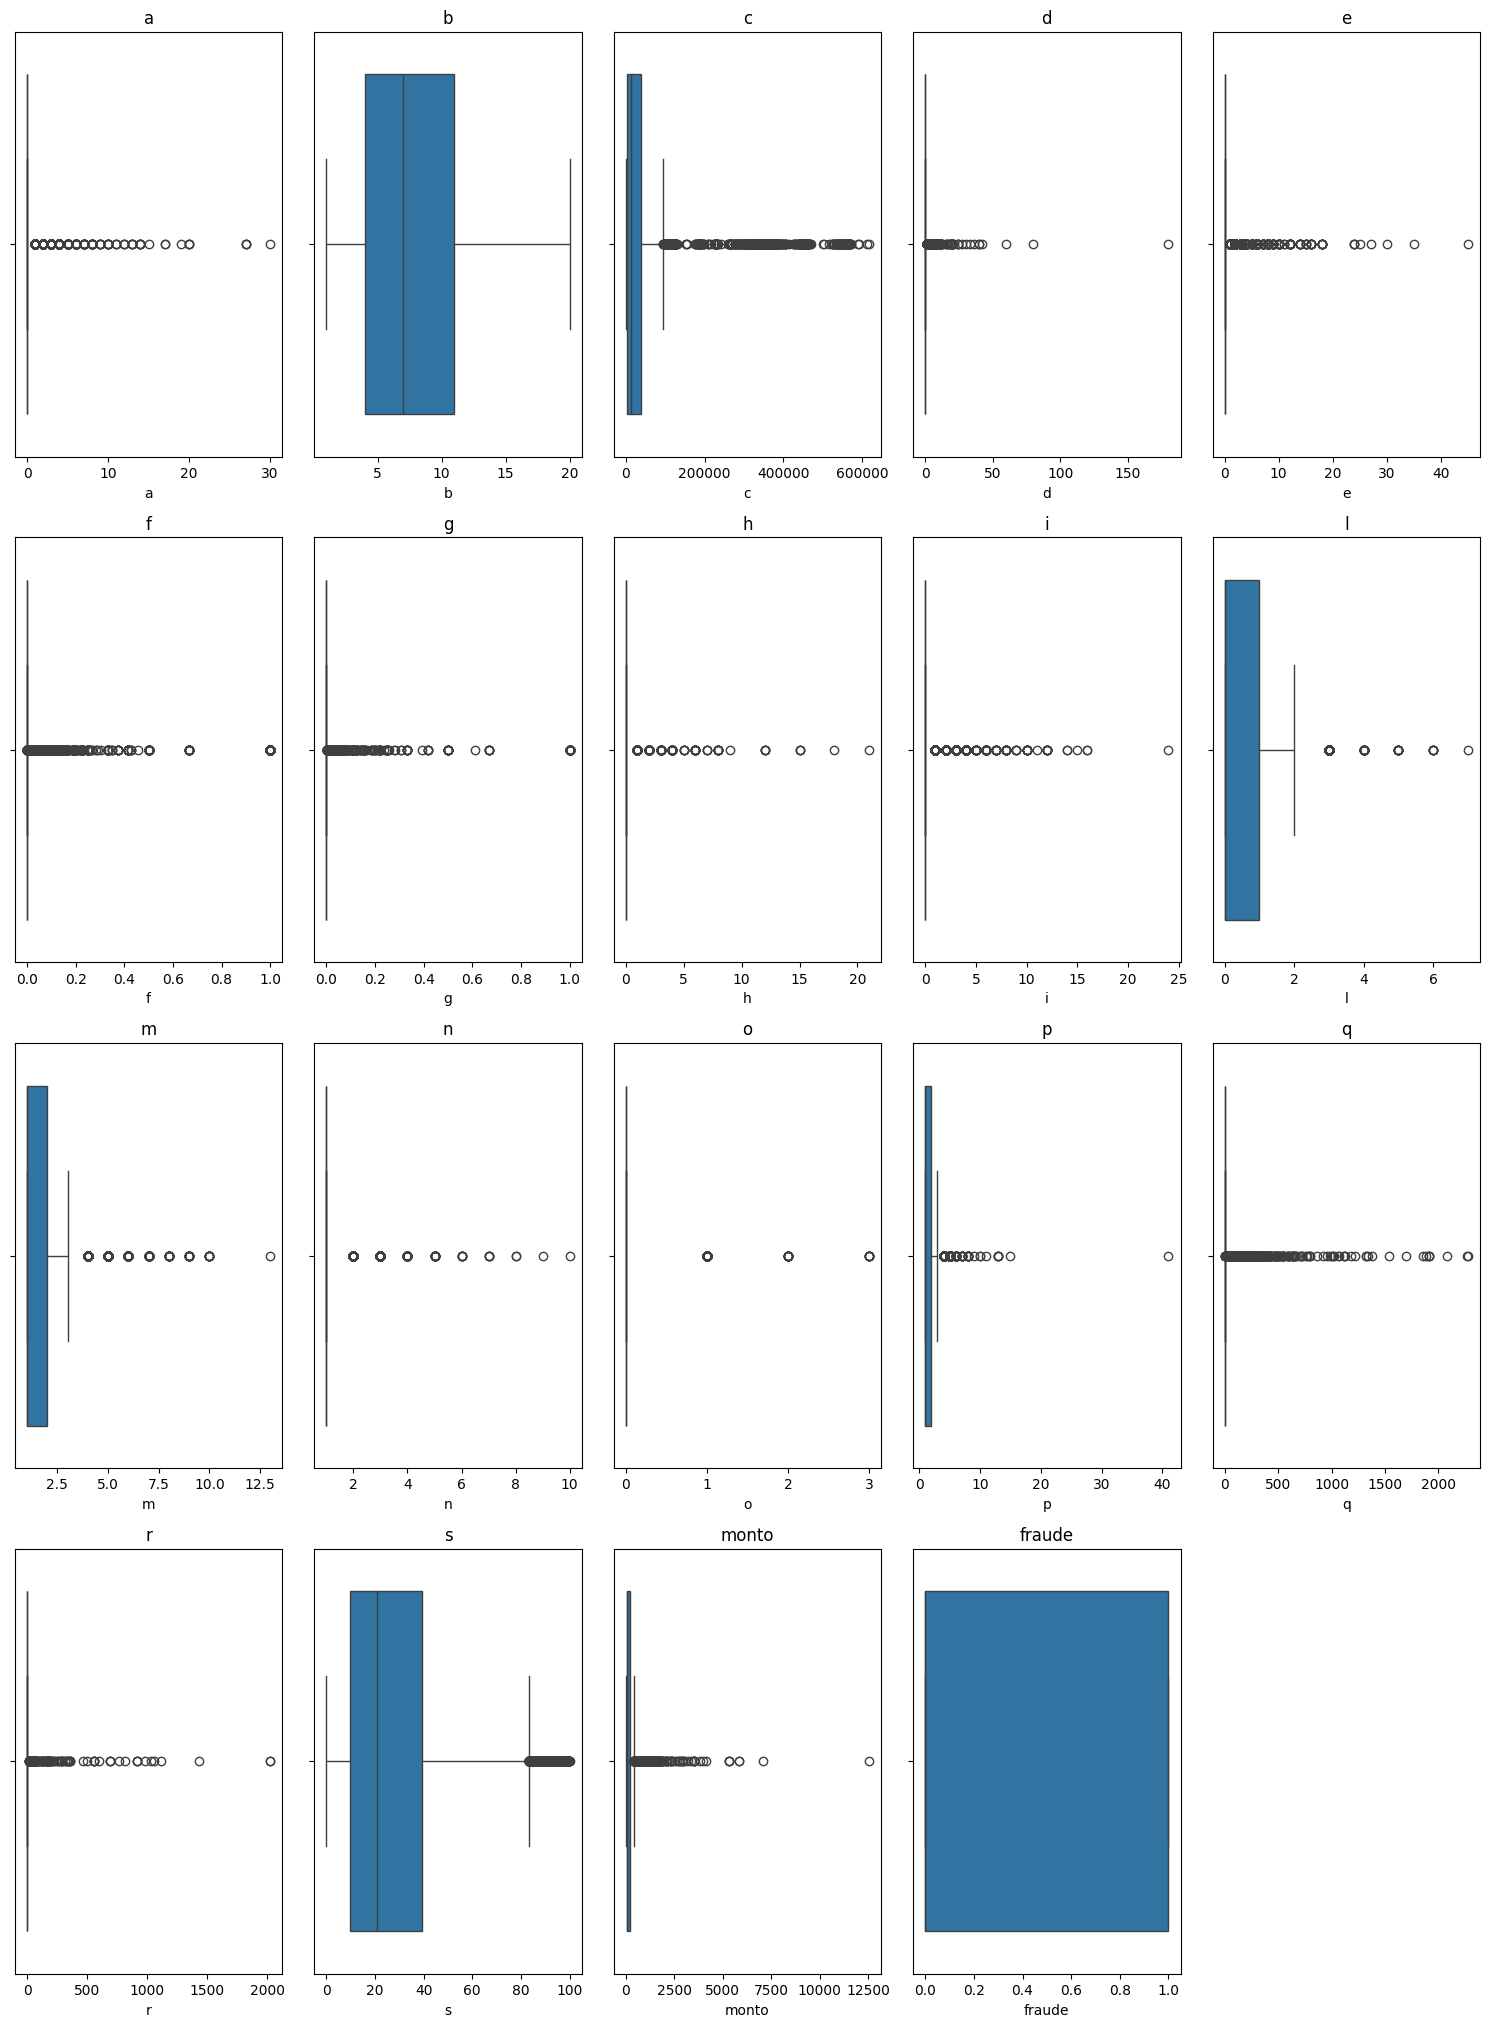

In [182]:
num_cols = 5
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
num_plots = len(numeric_columns)
num_rows = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()
for i, column in enumerate(numeric_columns):
    sns.boxplot(x=data[column], ax=axes[i])
    axes[i].set_title(column)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

Como podemos observar en nuestro dataset hay una alta presencia de outliers por lo tanto seria bueno intentar reducir estos para mejorar el modelo

Realizaremos una transformacion de raiz cuadrada a nuestro dataset para de esta manera ver si reducen la cantidad de outliers de nuestro dataset, exluiremos la variable objetivo ya que son solo `0` y `1`.

In [183]:
numerical_cols = data.select_dtypes(include=[np.number]).columns.drop('fraude')
data[numerical_cols] = np.sqrt(data[numerical_cols])

Realizemos graficos nuevamente para verificar si hubo en cambio en los outliers

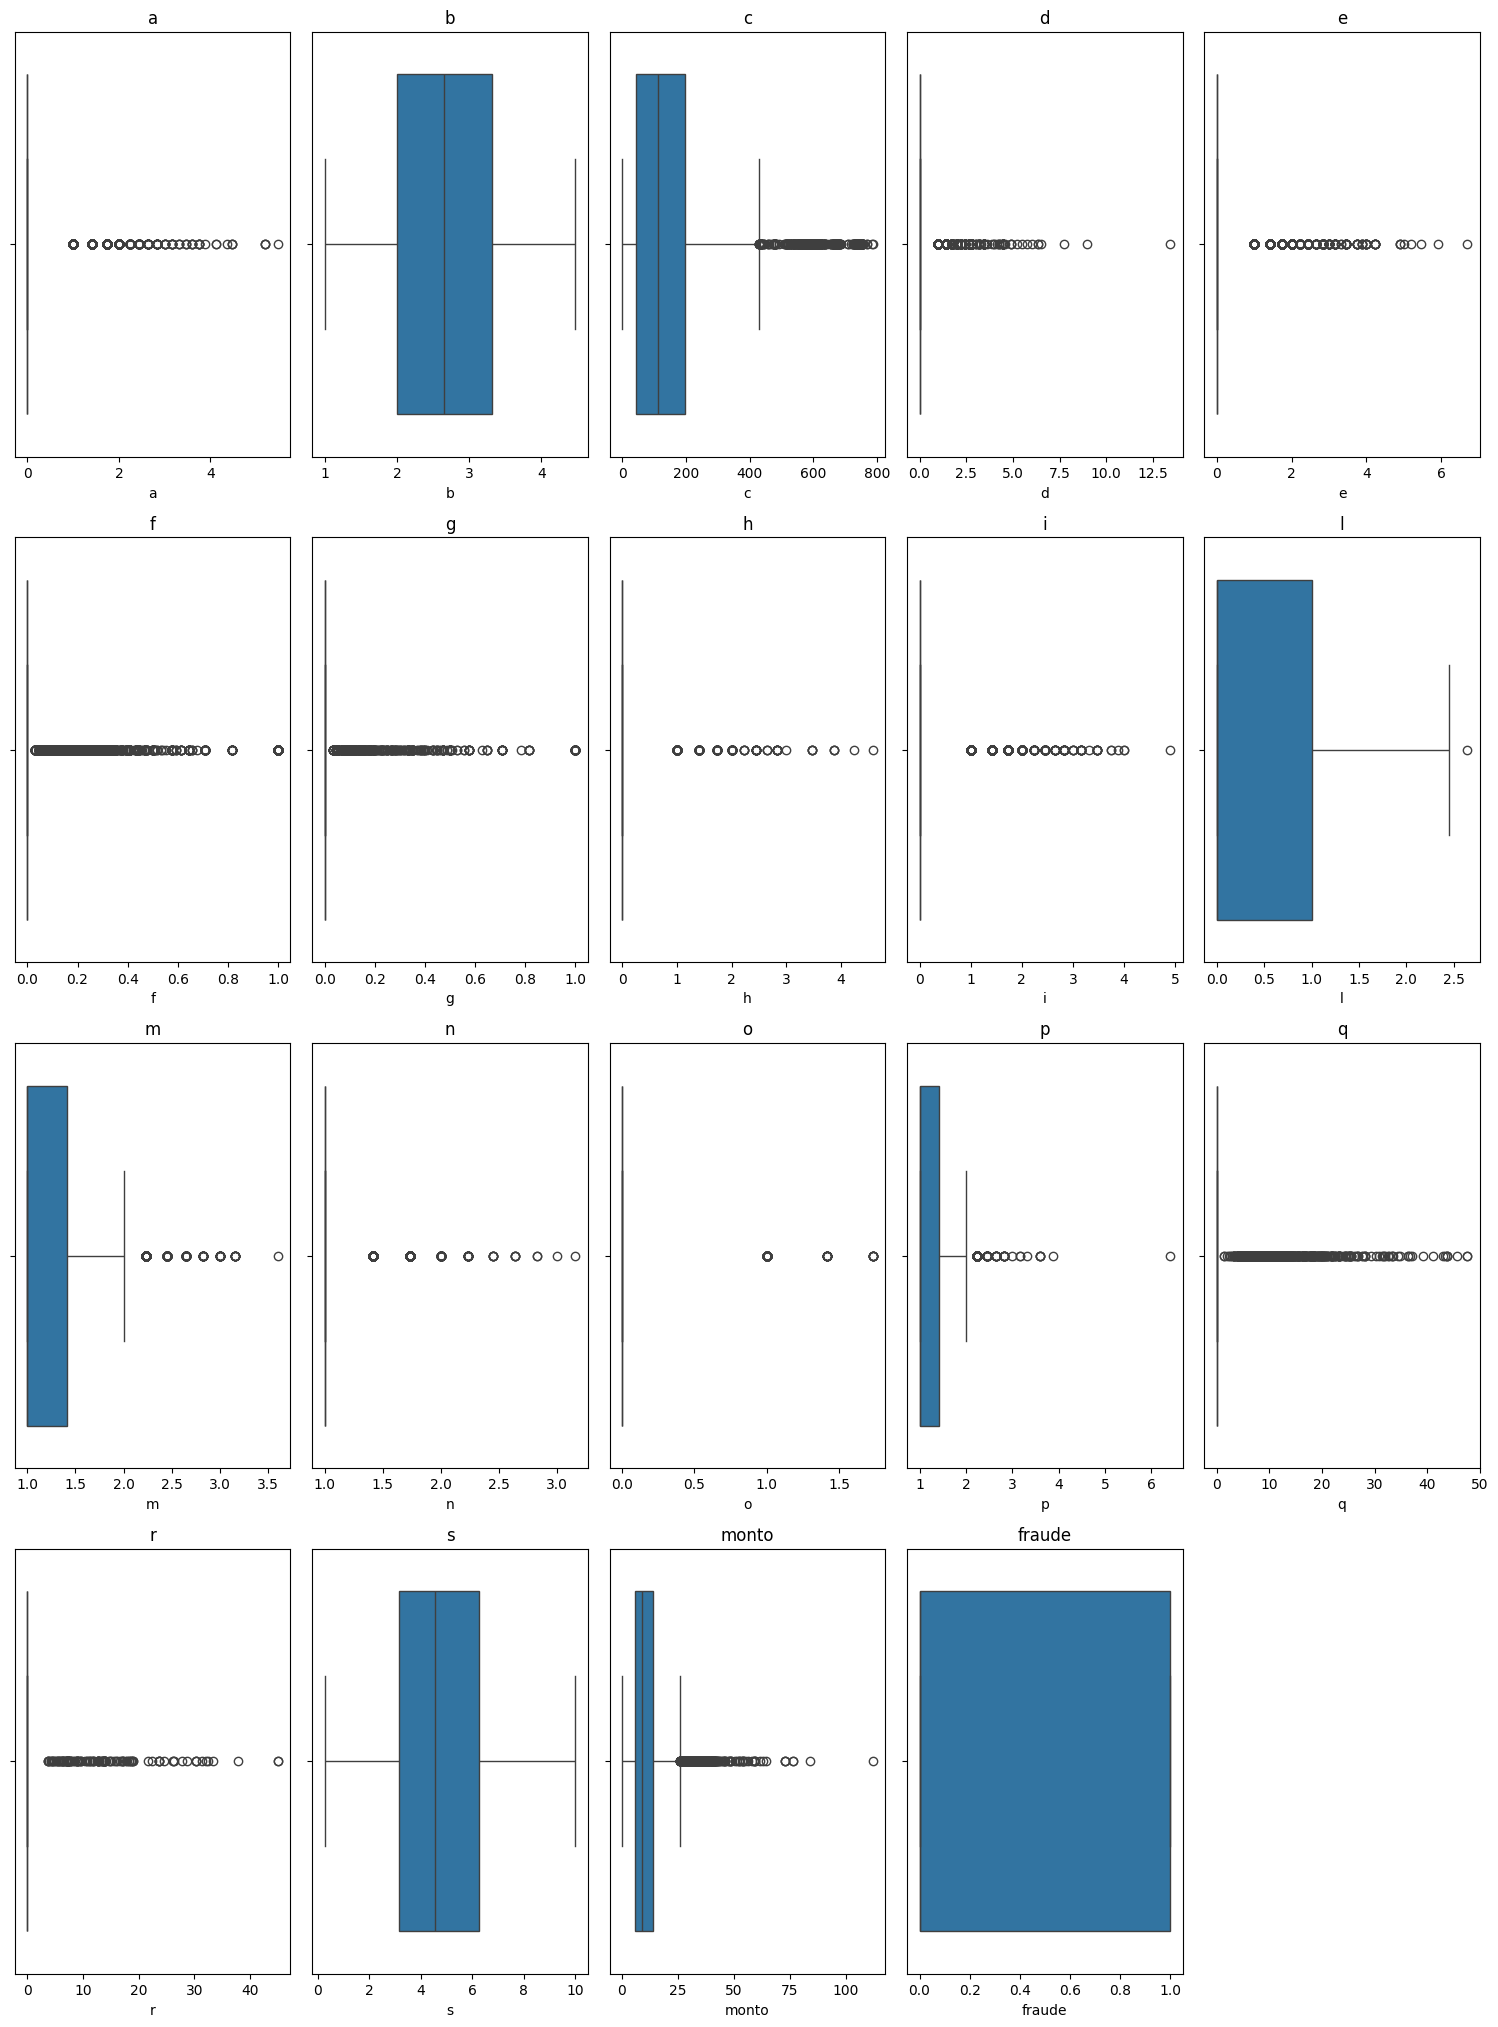

In [184]:
num_cols = 5
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
num_plots = len(numeric_columns)
num_rows = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()
for i, column in enumerate(numeric_columns):
    sns.boxplot(x=data[column], ax=axes[i])
    axes[i].set_title(column)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

En varias features hubo un buen cambio y se redujeron muchos outliers, pero sigue habiendo presencia de estos en las features.

Revisemos nuestra variable objetivo

fraude
0    12269
1     4611
Name: count, dtype: int64


<Axes: xlabel='fraude'>

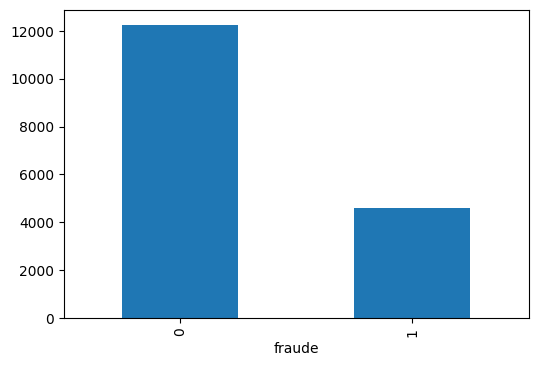

In [185]:
print(data['fraude'].value_counts())
data['fraude'].value_counts().plot(kind='bar' , figsize = (6,4))

Aunque hay una diferencia entre una y otra, no esta tan desbalanceada por lo tanto es positivo ya que no tendremos que usar tantos modelos para mejorar clases desbalanceadas

Analisemos nuestra variable categorica

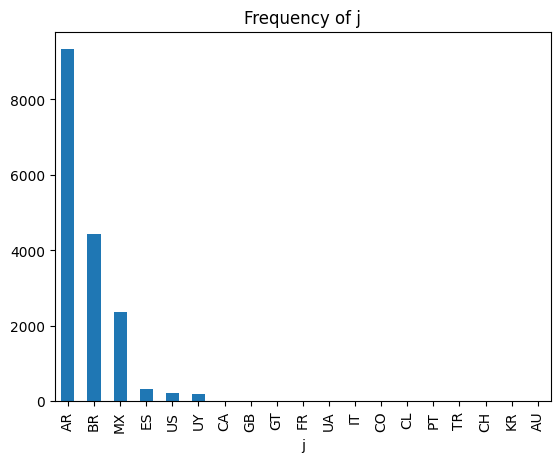

In [186]:
for column in data.select_dtypes(include=['object']).columns:
    plt.figure()
    data[column].value_counts().plot(kind='bar')
    plt.title(f'Frequency of {column}')
    plt.show()

Como podemos observar la mayor cantidad de datos se encuentra en los paises de `AR` , `BR` , `MX` , `ES` , `US` , `UY`

Veamos como se da la distribución de fraude en cada pais.

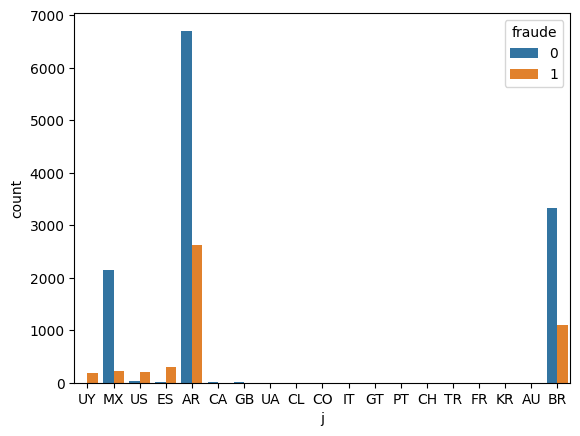

<Figure size 400x300 with 0 Axes>

In [187]:
for column in data.select_dtypes(include=['object']).columns:
    sns.countplot(x=column, hue='fraude', data=data)
    plt.figure(figsize=(4, 3))
    plt.show()

* Argentina (AR): Tiene la mayor cantidad de casos tanto de fraude como de no fraude, con más de 6000 casos de no fraude y alrededor de 3000 casos de fraude. Esto podría sugerir que Argentina es un punto crítico para la detección de fraudes.

* Brasil (BR): También muestra un número significativo de casos de no fraude (alrededor de 3000) y una cantidad menor de casos de fraude (alrededor de 1000). Similar a Argentina, Brasil es otro país con una actividad considerable que podría necesitar atención en la gestión de fraudes.

* México (MX): Tiene una cantidad considerable de casos de no fraude (alrededor de 2000) y una cantidad muy baja de casos de fraude. México parece tener un perfil de fraude más bajo en comparación con su volumen de transacciones.

* Uruguay (UY), Estados Unidos (US) y España (ES): Estos países tienen cantidades muy bajas de casos tanto de fraude como de no fraude, con menos de 500 casos en cada categoría. Esto podría indicar que en estos países la actividad de fraude es menos prevalente o que las transacciones en general son menos frecuentes.

De acuerdo a esto realizaremos one hot encoding para poder tratar con esta variable numerica

In [188]:
def apply_one_hot_encoding(data, columns):
    for column in columns:
        dummies = pd.get_dummies(data[column], prefix=column).astype(int)
        data = data.join(dummies).drop([column], axis=1)
    return data

one_hot_columns = ["j"]

data = apply_one_hot_encoding(data, one_hot_columns)

Contamos con 38 features para nuestro modelo

In [189]:
data.shape

(16880, 38)

In [190]:
data

,a,b,c,d,e,f,g,h,i,l,...,j_GB,j_GT,j_IT,j_KR,j_MX,j_PT,j_TR,j_UA,j_US,j_UY
0,0.0,3.162278,224.180731,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,3.162278,170.334964,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,2.645751,9.591663,0.0,1.000000,0.000000,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,4.000000,224.207493,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,2.828427,90.443352,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16875,0.0,1.732051,251.598887,0.0,1.000000,0.707107,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
16876,0.0,3.464102,28.722813,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
16877,1.0,1.732051,284.722672,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
16878,0.0,3.000000,631.167173,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Realizaremos graficas de las features vs la variable objetivo para identificar patrones

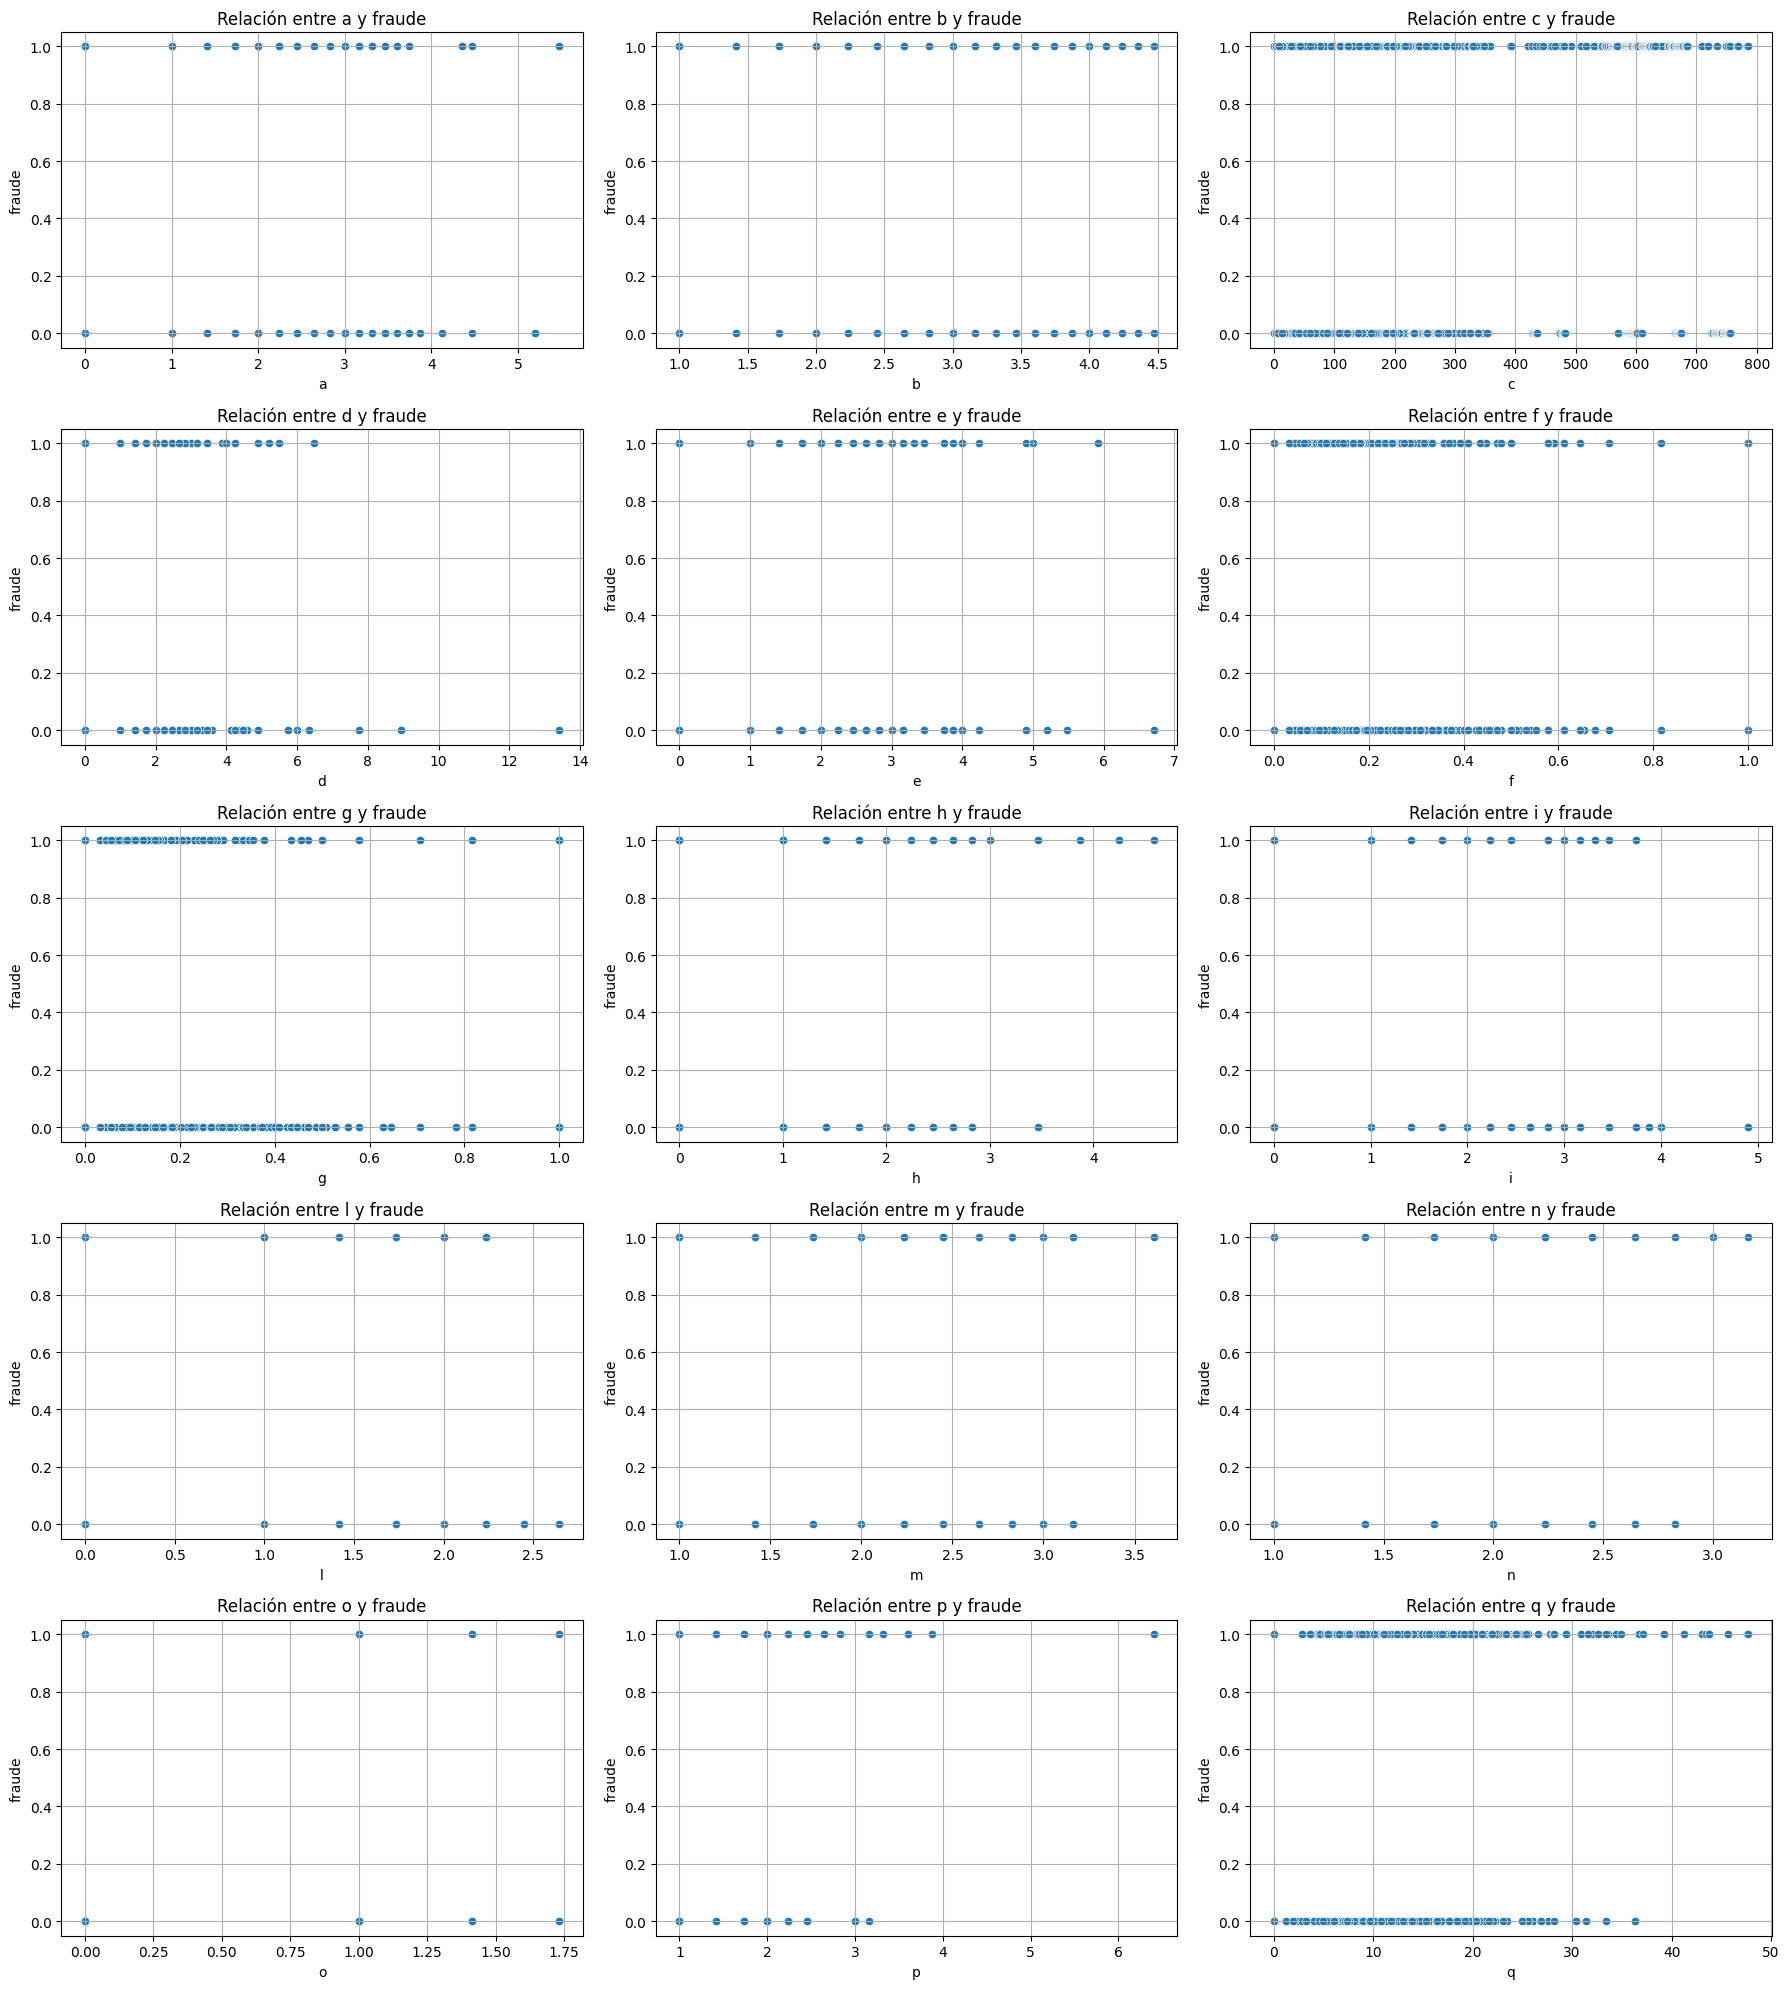

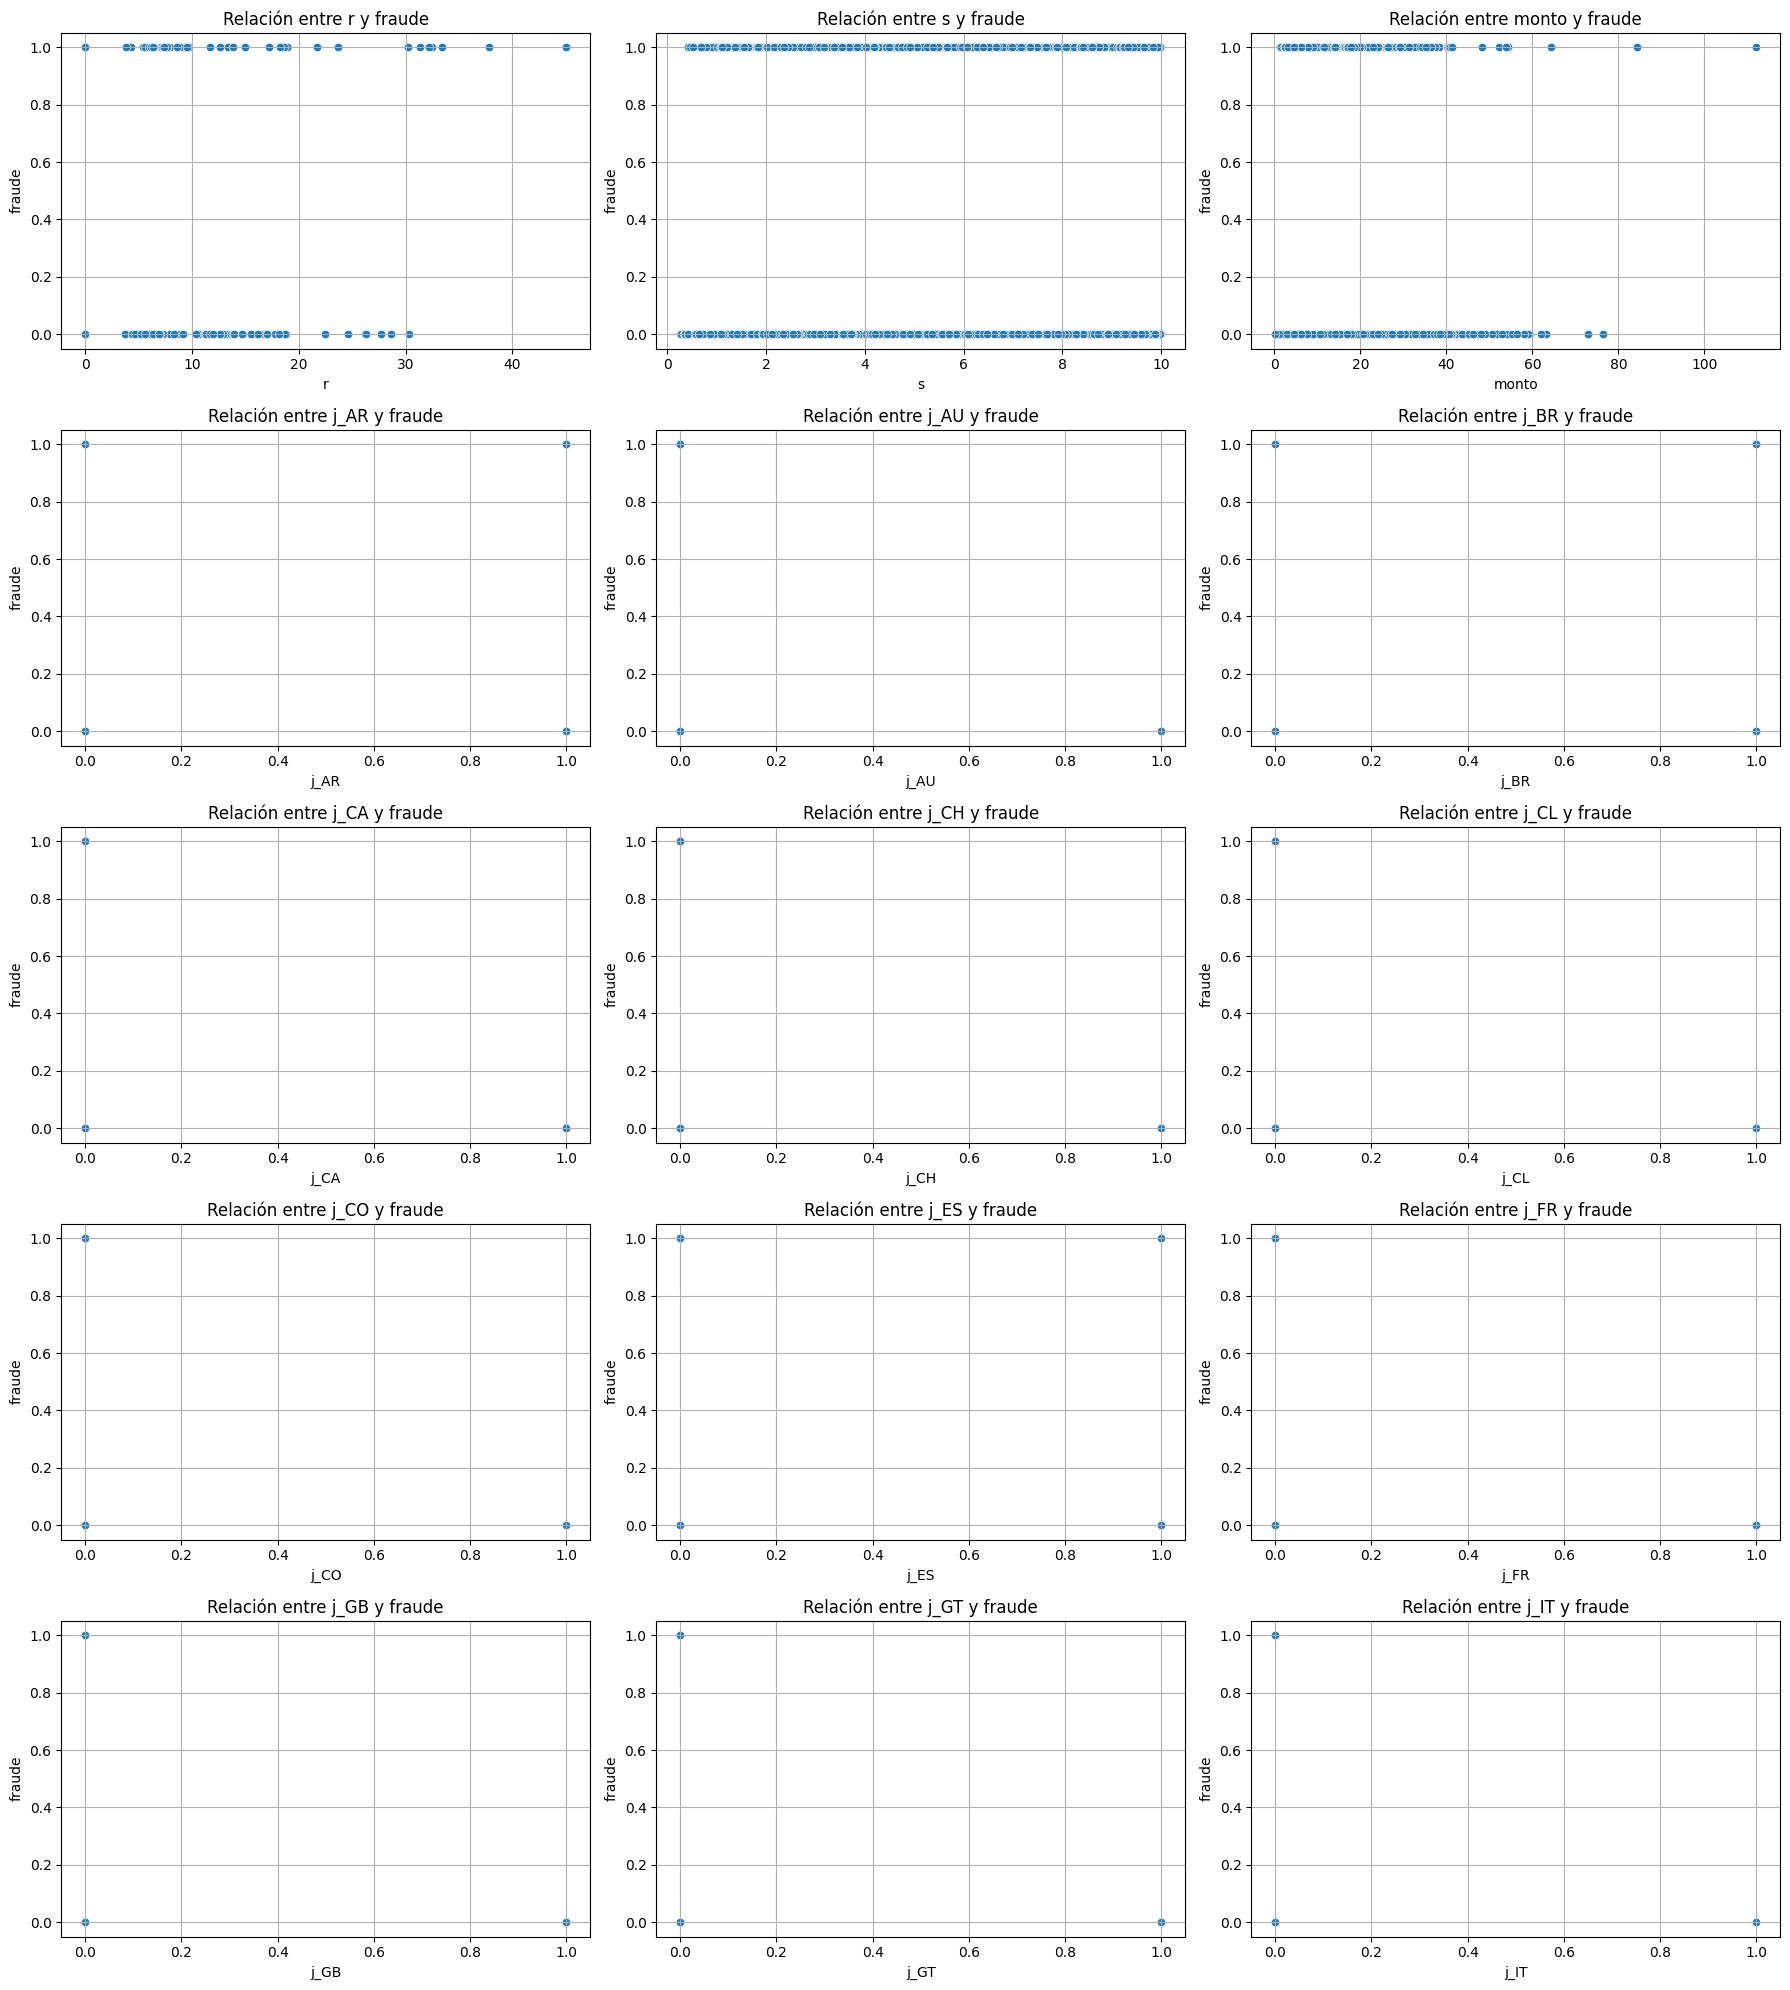

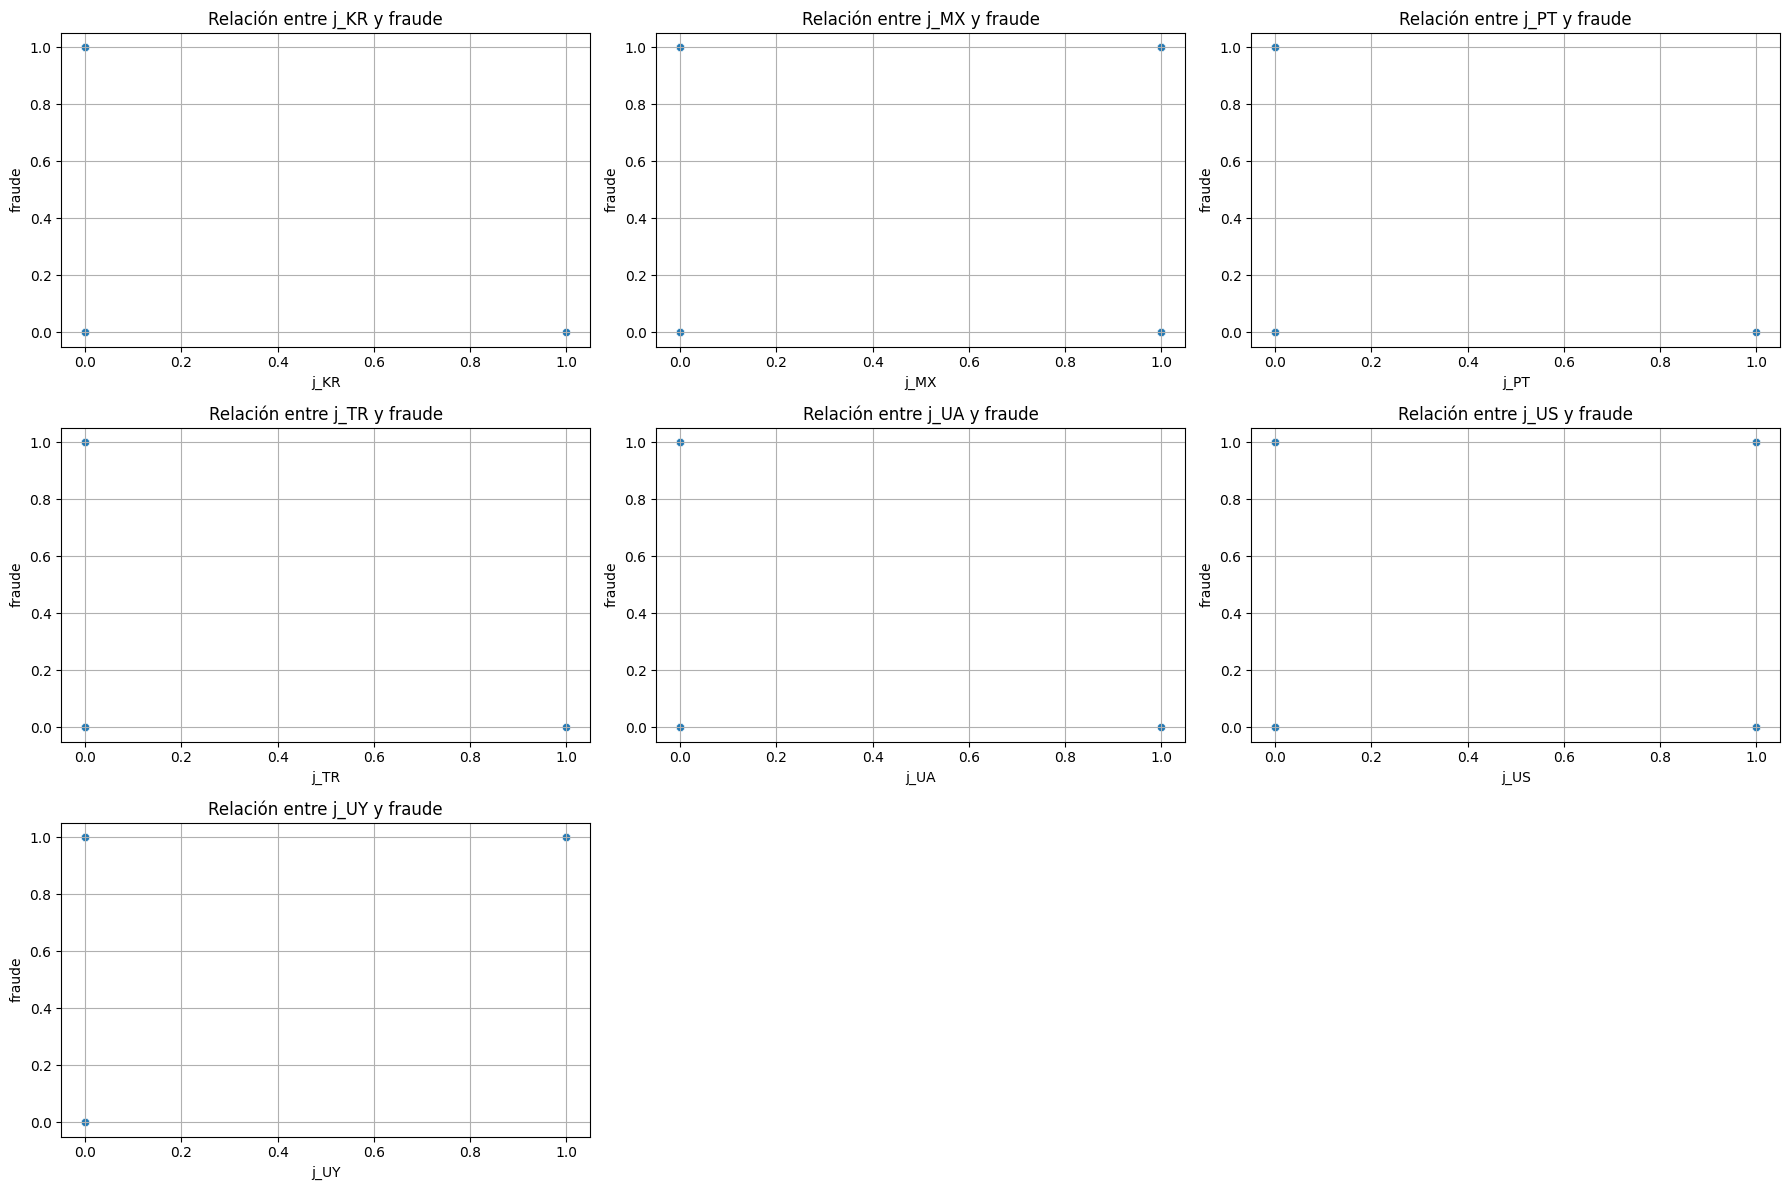

In [191]:
def plot_scatterplots_numerical_vs_target(data, target, plots_per_figure=15):
    # Seleccionar variables numéricas
    numerical_data = data.select_dtypes(include=['float64', 'int64'])

    # Excluir la variable objetivo de las variables a graficar
    columns_to_plot = [col for col in numerical_data.columns if col != target]

    # Calcular número de figuras necesarias
    num_plots = len(columns_to_plot)
    num_figures = int(np.ceil(num_plots / plots_per_figure))

    for fig_num in range(num_figures):
        # Calcular cuántos plots irán en esta figura
        start_idx = fig_num * plots_per_figure
        end_idx = min((fig_num + 1) * plots_per_figure, num_plots)
        current_columns = columns_to_plot[start_idx:end_idx]

        # Configurar el número de filas y columnas para esta figura
        num_cols = min(3, len(current_columns))
        num_rows = int(np.ceil(len(current_columns) / num_cols))

        # Crear nueva figura
        plt.figure(figsize=(18, num_rows * 4))

        for i, column in enumerate(current_columns):
            plt.subplot(num_rows, num_cols, i + 1)
            sns.scatterplot(x=data[column], y=data[target])
            plt.title(f'Relación entre {column} y {target}')
            plt.xlabel(column)
            plt.ylabel(target)
            plt.grid(True)

        plt.tight_layout()
        plt.show()

plot_scatterplots_numerical_vs_target(data, 'fraude')

No parece haber una relación clara y fuerte entre la mayoría de las variables y el fraude. La dispersión de puntos en cada gráfico no muestra una tendencia evidente.

Realizaremos la matriz de correlación para ver que tan correlacionadas estan nuestras features con la variable objetivo

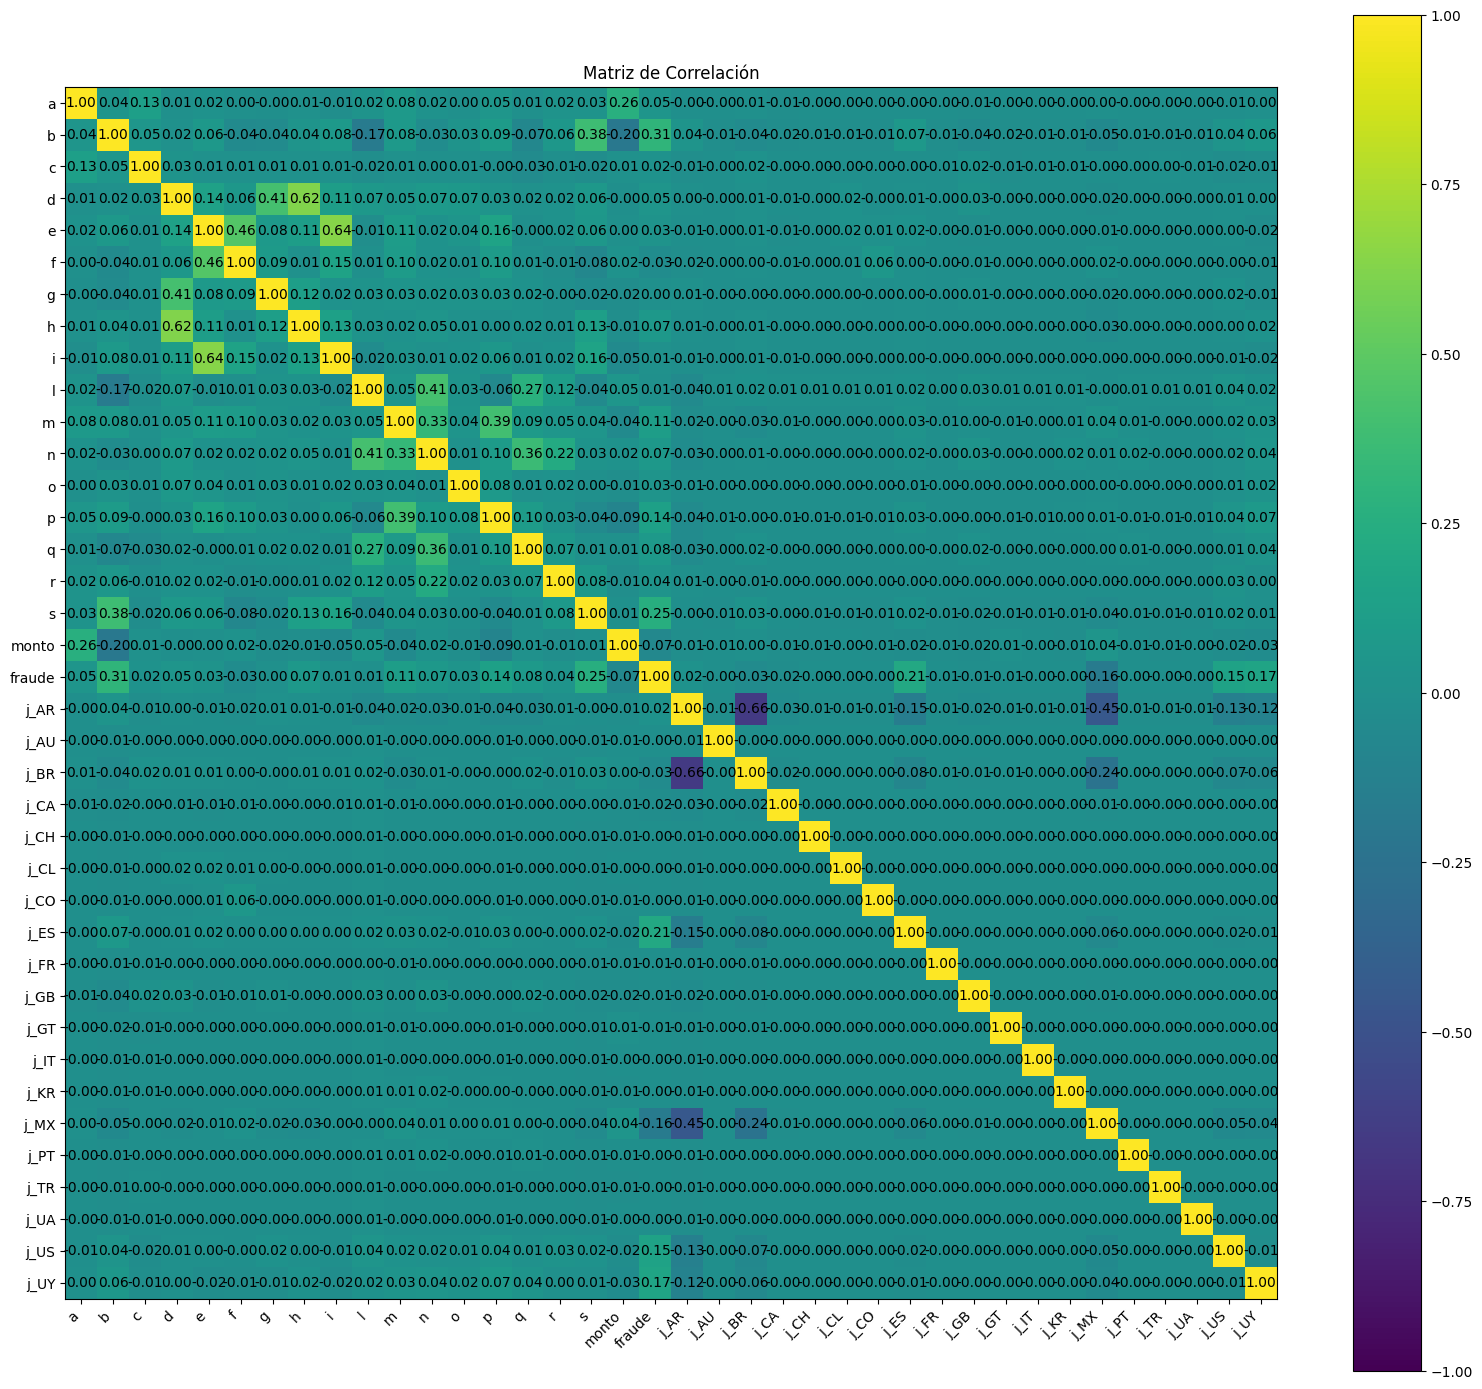

In [192]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_data.corr()

plt.figure(figsize=(16, 14))

plt.imshow(corr_matrix, cmap='viridis', interpolation='none', vmin=-1, vmax=1)
plt.colorbar()

plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.title('Matriz de Correlación')

plt.tight_layout()
plt.show()

Realizemos otra matriz pero con seaborn para facilitar su visualización

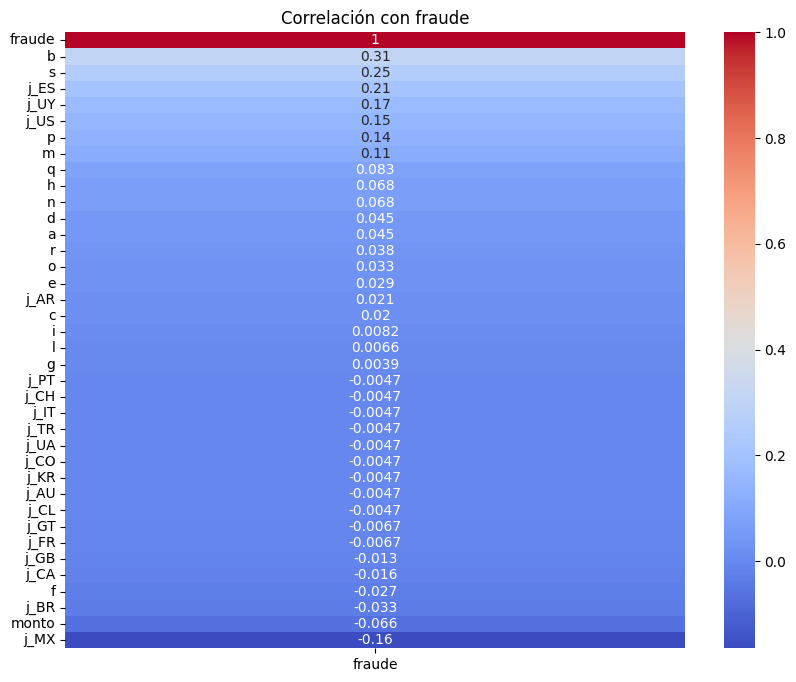

In [193]:
numerical_data = data.select_dtypes(include=['float64', 'int64'])
correlation = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation[['fraude']].sort_values(by='fraude', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlación con fraude')
plt.show()

Como podemos observar hay muchas features con poca correlacion, al momento de implementar nuestro modelo para la prediccion podemos obtar por eliminar algunas para probar si mejora este.

Podemos observamos como nuestro nuevo dataset tiene una estructura similar a la del dataset original, pero con algunas diferencias importantes. El dataset ya cuenta con las columnas agregadas del one hot encoding

In [194]:
data

,a,b,c,d,e,f,g,h,i,l,...,j_GB,j_GT,j_IT,j_KR,j_MX,j_PT,j_TR,j_UA,j_US,j_UY
0,0.0,3.162278,224.180731,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,3.162278,170.334964,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,2.645751,9.591663,0.0,1.000000,0.000000,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,4.000000,224.207493,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,2.828427,90.443352,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16875,0.0,1.732051,251.598887,0.0,1.000000,0.707107,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
16876,0.0,3.464102,28.722813,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
16877,1.0,1.732051,284.722672,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
16878,0.0,3.000000,631.167173,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Ya tras haber realizado nuestra EDA, podemos empezar en montar nuestro modelo de preferencia

# Divisón de nuesto dataset:

In [195]:
X = data.drop('fraude', axis=1)
y = data['fraude']

In [196]:
y.value_counts()

fraude
0    12269
1     4611
Name: count, dtype: int64

Al revisar la cantidad de datos de nuestro traget podemos apreciar que esta desbalanceada, por lo tanto necesitamos implementar nuevas estrategias para tratar el problema

Primero se dividira el dataset en entrenamiento (76%) y un conjunto temporal (24%).
Luego, el conjunto temporal se divide en validación (10% del total) y prueba (10% del total)

In [197]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.24, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [198]:
len(X_train) , len(X_val) , len(X_test)

(12828, 2026, 2026)

En problemas de clasificación con un desbalance de clases, donde una clase tiene muchos más ejemplos que la otra (por ejemplo, en un problema de predicción de baja de clientes, donde la clase positiva podría ser mucho menos frecuente que la clase negativa), el modelo tiende a aprender más sobre la clase mayoritaria, ignorando o no aprendiendo de manera adecuada sobre la clase minoritaria. Este desbalance puede afectar negativamente el rendimiento del modelo, especialmente en métricas como el **recall** y el **F1-score** para la clase minoritaria.

El **undersampling** es una técnica que se utiliza para equilibrar el número de muestras entre las clases. Consiste en reducir el número de ejemplos de la clase mayoritaria, para que el modelo tenga una cantidad más equilibrada de ejemplos de cada clase durante el entrenamiento. Esto permite que el modelo aprenda de manera más equitativa y pueda predecir mejor la clase minoritaria.


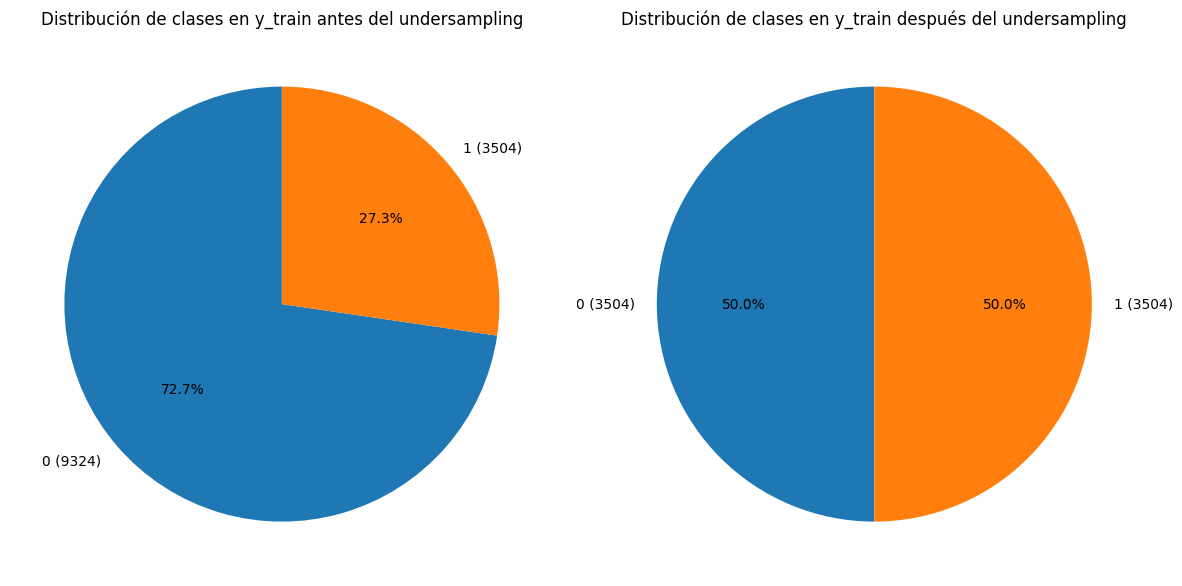

In [ ]:
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Función para mostrar cantidad y porcentaje en el gráfico de torta
def pie_with_count_and_percentage(ax, data, title):
    counts = data.value_counts()
    labels = [f"{label} ({count})" for label, count in zip(counts.index, counts)]
    ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de torta antes del undersampling
pie_with_count_and_percentage(axes[0], y_train, 'Distribución de clases en y_train antes del undersampling')

# Gráfico de torta después del undersampling
pie_with_count_and_percentage(axes[1], pd.Series(y_train_resampled), 'Distribución de clases en y_train después del undersampling')

plt.tight_layout()
plt.show()


### ¿Por qué realizamos GridSearchCV en el Modelo?

**GridSearchCV** es una técnica para encontrar los mejores hiperparámetros de un modelo, optimizando su rendimiento. En este caso, estamos utilizando **XGBoost** para clasificación, y buscamos los parámetros óptimos de la malla definida en `param_grid`. Este proceso evalúa todas las combinaciones posibles de parámetros con validación cruzada, optimizando una métrica (F1-score en este caso).

- **param_grid** define los valores posibles de los hiperparámetros como `learning_rate`, `max_depth`, y `n_estimators`.
- **GridSearchCV** realiza la búsqueda en la malla, evaluando el rendimiento con validación cruzada (`cv=3`) y seleccionando el conjunto de parámetros que maximiza el **F1-score**.
- Después de ajustar el modelo con los mejores parámetros, evaluamos su rendimiento en los conjuntos de **validación** y **test**.

Este proceso mejora el modelo al encontrar la mejor configuración posible y evaluarla de manera robusta, usando todos los núcleos disponibles para acelerar el ajuste.

In [200]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1

)

# Ajustar el modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtener los mejores parámetros y modelo
print("Mejores Parámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluar en el conjunto de validación
y_val_pred = best_model.predict(X_val)
print("Accuracy en Validación:", accuracy_score(y_val, y_val_pred))
print("Reporte de Clasificación:\n", classification_report(y_val, y_val_pred))

# Evaluar en el conjunto de testeo
y_test_pred_xgboost = best_model.predict(X_test)
print("\nXGBoost Model Evaluation on Test Set:")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_xgboost))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_xgboost))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred_xgboost))

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Mejores Parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
Accuracy en Validación: 0.730009871668312
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.89      0.72      0.79      1472
           1       0.50      0.76      0.61       554

    accuracy                           0.73      2026
   macro avg       0.70      0.74      0.70      2026
weighted avg       0.78      0.73      0.74      2026


XGBoost Model Evaluation on Test Set:
Test Accuracy: 0.7443237907206318
Test Confusion Matrix:
 [[1092  381]
 [ 137  416]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.74      0.81      1473
           1       0.52      0.75      0.62       553

    accuracy                           0.74      2026
   macro avg       0.71

 El modelo muestra una precisión alta para la clase 0, tanto en validación como en prueba, lo que indica que el modelo es muy efectivo en la predicción de la clase mayoritaria.

 Aunque el recall para la clase positiva es relativamente alto, la precisión es más baja, lo que sugiere que el modelo tiende a clasificar algunos negativos como positivos, aunque no lo hace en exceso (debido al buen recall).

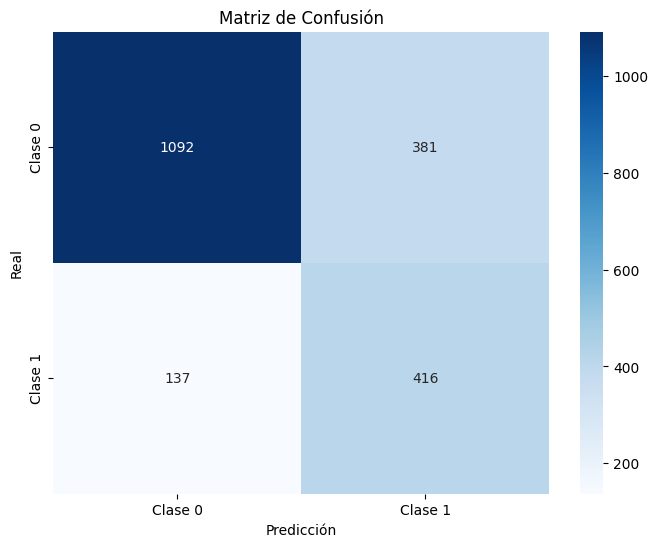

In [201]:
conf_matrix = confusion_matrix(y_test, y_test_pred_xgboost)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Segun la matriz de confusión el modelo tiene un buen desempeño en la predicción de la clase 0, pero presenta una mayor confusión al diferenciar entre las clases 0 y 1, con más errores de clasificación en la clase 1.

AUC: 0.8298086544498509


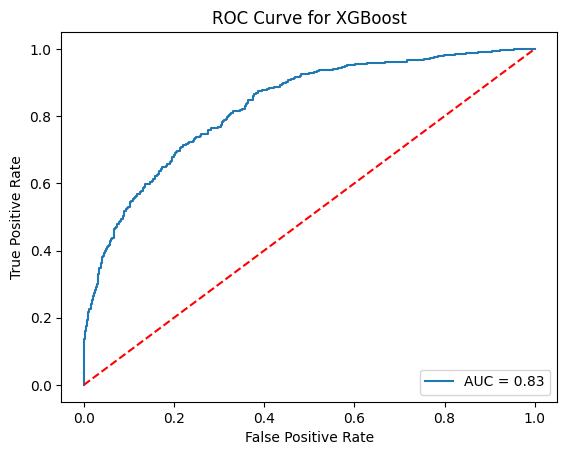

In [202]:
y_val_prob_xgboost = best_model.predict_proba(X_val)[:, 1]
auc_xgboost = roc_auc_score(y_val, y_val_prob_xgboost)
print("AUC:", auc_xgboost)

fpr_xgboost, tpr_xgboost, _ = roc_curve(y_val, y_val_prob_xgboost)

plt.plot(fpr_xgboost, tpr_xgboost, label=f"AUC = {auc_xgboost:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost")
plt.legend(loc="lower right")
plt.show()

La curva ROC muestra que el modelo XGBoost tiene un buen desempeño predictivo para la detección de fraude, con un AUC de 0.83 que indica una alta capacidad discriminativa.

   Feature  Importance
31    j_MX    0.126034
25    j_ES    0.091297
1        b    0.089864
35    j_US    0.078995
36    j_UY    0.077981
14       q    0.044983
10       m    0.041347
16       s    0.039241
13       p    0.038781
12       o    0.029762
0        a    0.029665
18    j_AR    0.028861
9        l    0.027678
2        c    0.027046
3        d    0.025980
17   monto    0.025422
8        i    0.024469
20    j_BR    0.024467
5        f    0.023314
7        h    0.023144
4        e    0.020959
11       n    0.020769
6        g    0.020748
15       r    0.019194
19    j_AU    0.000000
24    j_CO    0.000000
21    j_CA    0.000000
23    j_CL    0.000000
22    j_CH    0.000000
28    j_GT    0.000000
27    j_GB    0.000000
26    j_FR    0.000000
29    j_IT    0.000000


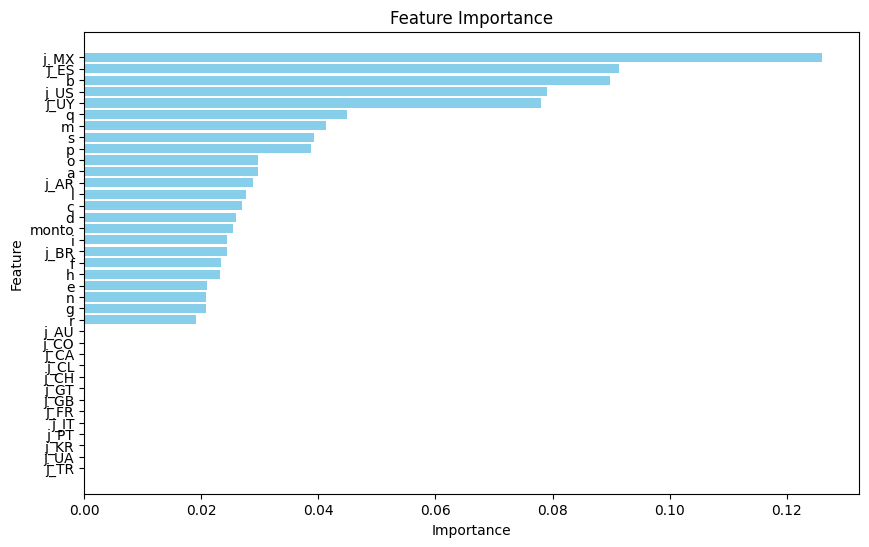

In [203]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener las importancias de las características
feature_importances = best_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(33))
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

El grafico de barras nos proporciona la importancia de las features, podemos resaltar como la feature con mayor importancia es la de `j_mx`, tambien podemos observar como las ultimas features en las que se realizo one hot enconding practicamente no nos estan proporciona nada de importancia al modelo.

# Conclusiones 


### 1. **Distribución de Clases**
- **Antes del Undersampling:** La distribución de clases está desbalanceada, con una clara mayoría de la clase 0 (no fraude) sobre la clase 1 (fraude).
- **Después del Undersampling:** El undersampling ha equilibrado las clases, reduciendo tanto la clase 0 como la clase 1 a un número igual de instancias. Esto ayuda a evitar el sesgo hacia la clase mayoritaria, pero puede perder información importante de la clase mayoritaria.

### 2. **Evaluación del Modelo en el Conjunto de Validación**
- **Accuracy:** 73% en el conjunto de validación. Aunque un buen valor, no es sobresaliente. Recuerda que en problemas de clases desbalanceadas, el **accuracy** no es suficiente para evaluar el modelo por completo.
- **Precision y Recall (Clase 1 - fraude):**
  - **Precision (0.50):** De todas las predicciones de fraude, solo el 50% fueron correctas. Esto indica que el modelo genera una cantidad considerable de **falsos positivos**.
  - **Recall (0.76):** El modelo logra un recall relativamente alto, detectando el 76% de los fraudes. Esto es positivo, pero también sugiere que el modelo aún podría mejorar en la detección.
- **F1-Score (0.61):** El **F1-score** muestra un balance moderado entre **precisión** y **recall**. Aunque es un buen valor, puede mejorarse, especialmente la precisión.

### 3. **Evaluación del Modelo en el Conjunto de Prueba**
- **Accuracy:** 74.4%, lo que indica que el modelo generaliza bien y no sobreajusta.
- **Confusion Matrix:**
  - **Falsos Positivos (FP):** 381 casos de fraude predichos erróneamente como no fraude.
  - **Falsos Negativos (FN):** 137 casos de fraude no detectados.
- **Precision y Recall (Clase 1 - fraude):**
  - **Precision (0.52):** La precisión es mejor que en el conjunto de validación, pero sigue siendo moderada. Esto refleja la necesidad de mejorar la capacidad del modelo para identificar correctamente los fraudes.
  - **Recall (0.75):** El recall sigue siendo alto, lo que indica que el modelo es bueno para identificar la mayoría de los fraudes, aunque aún deja pasar algunos.
- **F1-Score (0.62):** Similar al conjunto de validación, el F1-score es moderado, sugiriendo que hay espacio para mejorar el equilibrio entre precisión y recall.

### 4. **AUC (Área bajo la Curva ROC):**
- **AUC (0.83):** Un buen valor de AUC, lo que indica que el modelo tiene una capacidad discriminativa efectiva para diferenciar entre fraudes y no fraudes.

### 5. **Importancia de las Características:**
- Las características más importantes incluyen `j_MX`, `j_ES`, y `b`. Estas variables parecen ser clave para la predicción de fraude.
- Características como `j_FR`, `j_IT`, y `j_CL` tienen **importancia cero**, lo que sugiere que no aportan significativamente al modelo.
